# Midterm 1: Obstacle avoidance using ARUCO markers and A-Star/RRT

I will document my process to achieve at this solution.

## Thought process

1. Get object poses from ARUCO
2. Plan path through obstacles using A-star
3. Follow path by converting desired movements to cmd_vel

Always test the smallest software component you can test, so that errors are caught early. 

Our A-star algorithm from the discrete-planning notebook worked on discrete grids. Let's see if we can extend it to a robot that moves only forward or backward. 

## Code from previous notebooks

### PriorityQueueUpdatable (HW2)

In [1]:
#%%writefile hw2_solution.py # uncomment and run after you fill in with your HW2 solution
### Fill in with your HW2 solution or ask for the solution from the instructor. ### 

### A-star algorithm

In [2]:
%%writefile astar.py
from hw2_solution import PriorityQueueUpdatable
import sys
from dataclasses import dataclass, field
from typing import Any

# https://docs.python.org/3/library/queue.html#queue.PriorityQueue
@dataclass(order=True)
class PItem:
    dist: int
    node: Any=field(compare=False)

    # Make the PItem hashable
    # https://docs.python.org/3/glossary.html#term-hashable
    def __hash__(self):
        return hash(self.node)

def astar(graph, heuristic_dist_fn, start, goal, debug=False, debugf=sys.stdout):
    """
    edgecost: cost of traversing each edge
    
    Returns success and node2parent
    
    success: True if goal is found otherwise False
    node2parent: A dictionary that contains the nearest parent for node 
    """
    seen = set([start]) # Set for seen nodes.
    # Frontier is the boundary between seen and unseen
    frontier = PriorityQueueUpdatable() # Frontier of unvisited nodes as a Priority Queue
    node2parent = {start : None} # Keep track of nearest parent for each node (requires node to be hashable)
    hfn = heuristic_dist_fn # make the name shorter
    node2dist = {start: 0  } # Keep track of cost to arrive at each node
    search_order = []
    frontier.put(PItem(0 + hfn(start, goal), start)) #   <------------- Different from dijkstra
    
    if debug: debugf.write("goal = "  + str(goal) + '\n')
    i = 0
    while not frontier.empty():          # Creating loop to visit each node
        dist_m = frontier.get() # Get the smallest addition to the frontier
        if debug: debugf.write("%d) Q = " % i + str(list(frontier.queue)) + '\n')
        if debug: debugf.write("%d) node = " % i + str(dist_m) + '\n')
        #if debug: print("dists = " , [node2dist[n.node] for n in frontier.queue])
        m = dist_m.node
        m_dist = node2dist[m]
        search_order.append(m)
        if goal is not None and m == goal:
            return True, search_order, node2parent, node2dist

        for neighbor, edge_cost in graph.get(m, []):
            old_dist = node2dist.get(neighbor, float("inf"))
            new_dist = edge_cost +  m_dist 
            if neighbor not in seen:
                seen.add(neighbor)
                frontier.put(PItem(new_dist +  hfn(neighbor, goal), neighbor)) # <------------- Different from dijkstra
                node2parent[neighbor] = m
                node2dist[neighbor] = new_dist
            elif new_dist < old_dist:
                node2parent[neighbor] = m
                node2dist[neighbor] = new_dist
                # ideally you would update the dist of this item in the priority queue
                # as well. But python priority queue does not support fast updates
                # ------------- Different from dijkstra --------------------
                old_item = PItem(old_dist + hfn(neighbor, goal), neighbor)
                if old_item in frontier:
                    frontier.replace(
                        old_item, 
                        PItem(new_dist + hfn(neighbor, goal), neighbor))
        i += 1
    if goal is not None:
        return False, search_order, node2parent, node2dist
    else:
        return True, search_order, node2parent, node2dist

def backtrace_path(node2parent, start, goal):
    c = goal
    r_path = [c]
    parent = node2parent.get(c, None)
    while parent != start:
        r_path.append(parent)
        c = parent
        parent = node2parent.get(c, None) # Keep getting the parent until you reach the start
        #print(parent)
    r_path.append(start)
    return reversed(r_path) # Reverses the path

Overwriting astar.py


## Creating a discrete maze

In [3]:
# Define the bounds of the maze
import numpy as np
state_min = np.array([
    -1.0, # x min in meters
    -1.0, # y min in meters
    -np.pi # theta min in radians
])
state_max = np.array([
    1.0, # x max in meters
    1.0, # y max in meters
    np.pi # theta max in radians
])
state_discrete_step = np.array([
    0.01, # x min in meters
    0.01, # y min in meters
    np.pi/10 # theta min in radians
])
# Let's put obstacles somewhere (arbitrary for now)
obstacles = np.array([
    [0.7, 0.7],
    [-0.7, 0.7]
])
# Let's put goal somewhere (arbitrary for now)
goal = np.array([0, 0.9])

# The robot must start with a state
start_state = np.array([0.0, 0.0, np.pi/3])

Defining numbers is good, but visualizing them is even better. Let's create some visualization code that show the robot and obstacles.

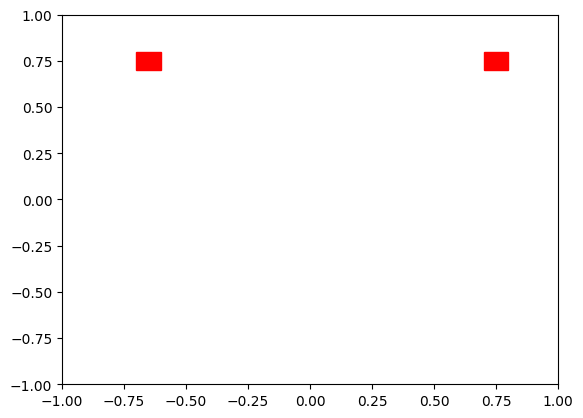

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.set_xlim(state_min[0], state_max[0])
ax.set_ylim(state_min[1], state_max[1])

# Draw the obstacle as rectangles
# Had to google matplotlib + draw rectangle
# https://stackoverflow.com/questions/37435369/how-to-draw-a-rectangle-on-image
for obs in obstacles:
    rect = patches.Rectangle((obs[0], obs[1]), 0.1, 0.1, linewidth=1, edgecolor='r', facecolor='r')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

You should test the code often. Usually I would keep modifying the code after editing the rectangles, but to show the intermediate state of the code, I leave the above cell as it is. I modify a copy of the code below. The below code was tested multiple times before 

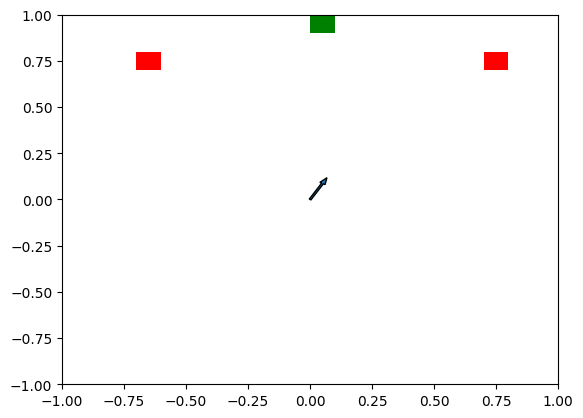

In [5]:

fig, ax = plt.subplots()
ax.set_xlim(state_min[0], state_max[0])
ax.set_ylim(state_min[1], state_max[1])

# Draw the obstacle as rectangles
# Had to google matplotlib + draw rectangle
# https://stackoverflow.com/questions/37435369/how-to-draw-a-rectangle-on-image
for obs in obstacles:
    orect = patches.Rectangle(obs, 0.1, 0.1, facecolor='r')
    # Add the patch to the Axes
    ax.add_patch(orect)

# Draw the goal as a rectangle
grect = patches.Rectangle(goal, 0.1, 0.1, facecolor='g')
ax.add_patch(grect)

# Draw the robot as an arrow
# Google: matplotlib draw arrow
ax.arrow(start_state[0], start_state[1], 
         0.1*np.cos(start_state[2]), 0.1*np.sin(start_state[2]),
        width=0.008)

Looks like we are wasting a lot of space. Also we will need to visualize this many times. Let's make a function out of this.

<Axes: >

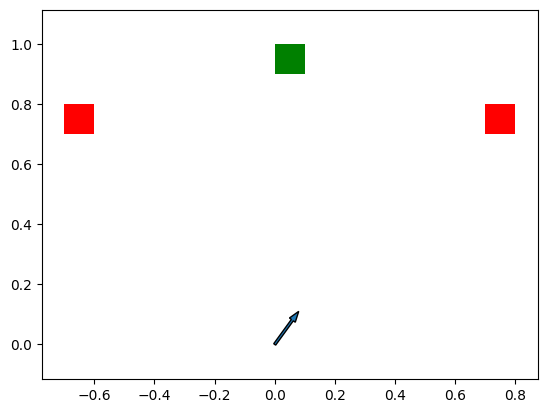

In [6]:
from dataclasses import dataclass
@dataclass
class MapProperties:
    state_min : np.ndarray 
    state_max : np.ndarray
    state_discrete_step : np.ndarray
    obstacles : np.ndarray

def plot_map(ax, map_properties, goal, current_state,
            obstaclesize=0.1,
            goalsize=0.1,
            robotsize=0.1,
            obstaclecolor='r',
            goalcolor='g'):
    state_min = map_properties.state_min
    state_max = map_properties.state_max
    obstacles = map_properties.obstacles
    ax.set_xlim(state_min[0], state_max[0])
    ax.set_ylim(state_min[1], state_max[1])
    ax.axis('equal') # keeps square obstacles square
    
    # Draw the obstacle as rectangles
    # Had to google matplotlib + draw rectangle
    # https://stackoverflow.com/questions/37435369/how-to-draw-a-rectangle-on-image
    for obs in obstacles:
        orect = patches.Rectangle(obs, obstaclesize, obstaclesize, facecolor=obstaclecolor)
        # Add the patch to the Axes
        ax.add_patch(orect)
    
    # Draw the goal as a rectangle
    grect = patches.Rectangle(goal, goalsize, goalsize, facecolor=goalcolor, label='goal')
    ax.add_patch(grect)
    
    # Draw the robot as an arrow
    # Google: matplotlib draw arrow
    ax.arrow(current_state[0], current_state[1], 
             robotsize*np.cos(current_state[2]), robotsize*np.sin(current_state[2]),
             width=0.08*robotsize,
             label='robot')
    return ax


map = MapProperties(
    state_min = np.array([
        -1.0, # x min in meters
        0.0, # y min in meters
        -np.pi # theta min in radians
    ]),
    state_max = np.array([
        1.0, # x max in meters
        1.0, # y max in meters
        np.pi # theta max in radians
    ]),
    state_discrete_step = np.array([
        0.01, # x min in meters
        0.01, # y min in meters
        np.pi/20 # theta min in radians
    ]),
    # Let's put obstacles somewhere (arbitrary for now)
    obstacles = np.array([
        [0.7, 0.7],
        [-0.7, 0.7]
    ])
)
# Let's put goal somewhere (arbitrary for now)
goal = np.array([0, 0.9])

# The robot must start with a state
start_state = np.array([0.0, 0.0, 3*np.pi/10])

fig, ax = plt.subplots()
plot_map(ax, map, goal, start_state)

It is always a good practice to (as we did above):
1. group related variables to classes (or dataclasses)
2. change the constants in the code to meaningful keyword arguments or constants.

This problem looks too easy on this visualization. Let's make it a bit harder by increasing the obstacle size and number. We can simplify it back when we move to the real robot.

[[ 0.7  0.7]
 [ 0.   0.4]
 [-0.7  0.7]]


<Axes: >

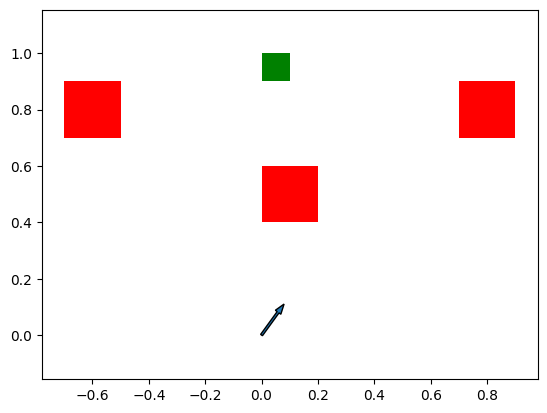

In [7]:
map.obstacles = np.array([
    [0.7, 0.7],
    [0.0, 0.4],
    [-0.7, 0.7]])
fig, ax = plt.subplots()
print(map.obstacles)
plot_map(ax, map, goal, start_state, obstaclesize=0.2)

Now we need to convert this obstacle list as as graph. Recall that the function astar uses only one function on graph:

```python
for neighbor, edge_cost in graph.get(m, [])
```

So we only need to implement a function that provides the possible neighbors of the current node (state) along with edge_cost (the cost of taking that action).

In [8]:
class ObstacleListToGraph:
    def __init__(self, map_properties):
        pass
    def get(self, current_state, default):
        nbrs = []
        return nbrs

Now what are neighbors of the robot state in current_state = [x, y, theta].

$$ s_t = [x_t, y_t, \theta_t] $$

This robot can move only forward, backward with linear velocity $v_t$ and rotate in place with angular velocity $\omega_t$.

\begin{align}
s_{t+1} =
\begin{bmatrix}
 x_{t+1} \\ y_{t+1} \\ \theta_{t+1}
 \end{bmatrix} 
 = 
\begin{bmatrix}
 x_{t} \\ y_{t} \\ \theta_{t}
 \end{bmatrix} 
 + 
\begin{bmatrix}
 v_t \cos(\theta_{t}) dt \\ v_t \sin(\theta_{t}) dt \\ \omega_{t} dt
 \end{bmatrix} 
\end{align}

This equation represents the state transition model. This particular equation is called the unicycle model.

What should be an ideal dt? Ideally, it should be as small as possible, approaching zero.

What should be good dt if we have already decided on a state_discrete_step $ = [\Delta x, \Delta y, \Delta \theta]$ size? It should be as small as possible, but at least big enough that when you are moving with minimum absolute linear velocity, you should at least land in the next discrete cell. Otherwise you will stay in the same cell until eternity.

$$ dt = \max\left(\frac{\sqrt{(\Delta x)^2 + (\Delta y)^2}}{|v_{min}|}, \frac{\Delta \theta}{|\omega_{min}|}\right) $$

In [9]:
from dataclasses import dataclass
@dataclass
class Robot:
    linvel_range: np.ndarray
    angvel_range: np.ndarray
    dt: float 

robot = Robot(linvel_range = np.array([0.1, 0.5]),
              angvel_range = np.array([np.pi/10, 3*np.pi/4]),
              dt = None)
robot.dt = max(
    np.sqrt((map.state_discrete_step[:2]**2).sum()) / np.abs(robot.linvel_range[0]),
    map.state_discrete_step[2] / np.abs(robot.angvel_range[0]))
robot.dt

0.5

## Creating a discrete graph

The state space is of size 3, so we need to create the graph in 3D. The neighbors of the graph are possible cells where the robot can go in the next time step dt. The full range of neighborhood is determined by min and max linear velocity and angular velocity. We will draw a straight line with the cells that are covered min by min and max linear velocity and all velocities within that range. And for each neighbor reachable by linear displacement we also have the angular velocity possibilities.

In [10]:
class ObstacleListToGraph:
    def __init__(self, map_properties, robot):
        self.map = map_properties
        self.robot = robot

    def _discretize(self, s):
        # divide by the step size, then round to convert the number to the nearest integer
        # and then multiply by the step size again.
        return np.round(s / self.map.state_discrete_step) * self.map.state_discrete_step

    def get(self, current_state, default=[]):
        vmin, vmax = self.robot.linvel_range
        omegamin, omegamax = self.robot.angvel_range
        step_size = self.map.state_discrete_step
        dt = self.robot.dt
        s = np.asarray(current_state)

        # The max and min state cells are governed by 
        # max and min velocity both linear and angular
        s = self._discretize(s)
        state_min = s + np.array([
            vmin * np.cos(s[2]) * dt,
            vmin * np.sin(s[2]) * dt,
            omegamin * dt])
        state_min = self._discretize(state_min)
        xy_min = state_min[:2]
        theta_min = state_min[2]
        
        state_delta = np.array([
            (vmax - vmin) * np.cos(s[2]) * dt,
            (vmax - vmin) * np.sin(s[2]) * dt,
            (omegamax - omegamin) * dt
        ])
        state_delta = self._discretize(state_delta)
        xy_delta = state_delta[:2]
        theta_delta = state_delta[2]
        
        xy_uniq_nbrs = self.get_lin_vel_nbrs(s, xy_delta, xy_min, step_size)
        
        state_nbrs = np.empty((len(xy_uniq_nbrs), len(s)))
        state_nbrs[:len(xy_uniq_nbrs), :2] = xy_uniq_nbrs 
        return state_nbrs
        
    def get_lin_vel_nbrs(self, s, xy_delta, xy_min, step_size):
        # all the cells that lie on the straight line between xy_delta+xy_min and xy_min are
        # possible neighbors.
        xy_dist = np.sqrt((xy_delta**2).sum())
        min_step = np.min(step_size[:2])
        xy_max_steps = xy_dist / min_step
        xy_dir = min_step * np.array([np.cos(s[2]), np.sin(s[2])])
        xy_nbrs = np.arange(xy_max_steps)[:, None]*xy_dir + xy_min
        xy_uniq_nbrs = np.unique(
            np.round(xy_nbrs / step_size[:2]).astype(dtype=np.int64),
            axis=0
        ) * step_size[:2]
        return xy_uniq_nbrs

This is a lot of code to be written in one go. Let's test it with different values, visualize it to see if it gives us the possible neighbors that we expect for different robot states.

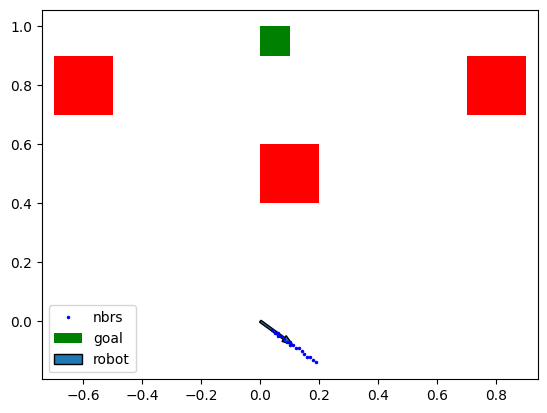

In [11]:
graph = ObstacleListToGraph(map, robot)
# start_state = np.array([0., 0., 3*np.pi/10])
# start_state = np.array([0., 0., 6*np.pi/10])
# start_state = np.array([0., 0., 9*np.pi/10])
# start_state = np.array([0., 0., 12*np.pi/10])
# start_state = np.array([0., 0., 15*np.pi/10])
start_state = np.array([0., 0., 18*np.pi/10])
# start_state = np.array([0., 0., 21*np.pi/10])
#start_state = np.array([0., 0., np.pi/10])
state_nbrs = graph.get(start_state)

fig, ax = plt.subplots()
ax.plot(state_nbrs[:, 0], state_nbrs[:, 1], 'bo', markersize=1.5, label='nbrs')
plot_map(ax, map, goal, start_state, obstaclesize=0.2)
ax.legend()

If the parameters do not look good to you about vmin, vmax, etc. Feel free to go back and edit them to make them more realistic.

Finding the set of cells  that are covered by a straight line in a discrete grid is a common problem in computer graphics and robotics. The proper way to find these are by [Bresenham's line algorithm](https://en.wikipedia.org/wiki/Bresenham's_line_algorithm). The code I wrote is just an inefficient way to do the same. The most inefficient part there is np.unique.

This looks a good set of neighbors in the forward direction. What about the reverse direction? The jetbot can move in reverse. Let's duplicate the set of neighbors in the opposite direction as well.

In [12]:
class ObstacleListToGraph:
    def __init__(self, map_properties, robot):
        self.map = map_properties
        self.robot = robot

    def _discretize(self, s):
        # divide by the step size, then round to convert the number to the nearest integer
        # and then multiply by the step size again.
        return np.round(s / self.map.state_discrete_step) * self.map.state_discrete_step

    def get(self, current_state, default=[]):
        vmin, vmax = self.robot.linvel_range
        omegamin, omegamax = self.robot.angvel_range
        step_size = self.map.state_discrete_step
        dt = self.robot.dt
        s = np.asarray(current_state)

        # The max and min state cells are governed by 
        # max and min velocity both linear and angular
        s = self._discretize(s)
        state_min = s + np.array([
            vmin * np.cos(s[2]) * dt,
            vmin * np.sin(s[2]) * dt,
            omegamin * dt])
        state_min = self._discretize(state_min)
        xy_min = state_min[:2]
        theta_min = state_min[2]
        
       
        state_delta = np.array([
            (vmax - vmin) * np.cos(s[2]) * dt,
            (vmax - vmin) * np.sin(s[2]) * dt,
            (omegamax - omegamin) * dt
        ])
        state_delta = self._discretize(state_delta)
        xy_delta = state_delta[:2]
        theta_delta = state_delta[2]
        
        xy_uniq_nbrs = self.get_lin_vel_nbrs(s, xy_delta, xy_min, step_size)
        
        xy_uniq_nbrs_opp = s[:2] - (xy_uniq_nbrs - s[:2])
        xy_both_side_nbrs = np.vstack((xy_uniq_nbrs, 
                                       xy_uniq_nbrs_opp))
        
        state_nbrs = np.empty((len(xy_both_side_nbrs), len(s)))
        state_nbrs[:len(xy_both_side_nbrs), :2] = xy_both_side_nbrs 
        return state_nbrs
        
    def get_lin_vel_nbrs(self, s, xy_delta, xy_min, step_size):
        # all the cells that lie on the straight line between xy_delta+xy_min and xy_min are
        # possible neighbors.
        xy_dist = np.sqrt((xy_delta**2).sum())
        min_step_size = np.min(step_size[:2])
        xy_max_steps = xy_dist / min_step_size
        xy_dir = min_step_size * np.array([np.cos(s[2]), np.sin(s[2])])
        xy_nbrs = np.arange(xy_max_steps)[:, None]*xy_dir + xy_min
        xy_uniq_nbrs = np.unique(
            np.round(xy_nbrs / step_size[:2]).astype(dtype=np.int64),
            axis=0
        ) * step_size[:2]
        return xy_uniq_nbrs

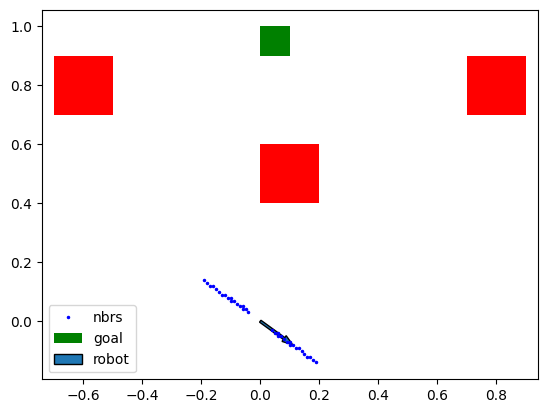

In [13]:
graph = ObstacleListToGraph(map, robot)
start_state = np.array([0., 0., 18*np.pi/10])
state_nbrs = graph.get(start_state)

fig, ax = plt.subplots()
ax.plot(state_nbrs[:, 0], state_nbrs[:, 1], 'bo', markersize=1.5, label='nbrs')
plot_map(ax, map, goal, start_state, obstaclesize=0.2)
ax.legend()

This looks like a set of good linear velocity neighbors but what about rotation? The jetbot can rotate in place and it can rotate while moving as well. 

#### Keeping angles wraparound in sight

We can follow the same process, but there is a catch. Unlike position, theta wraps around $360^\circ$. $360^\circ$ is exactly the same as $0^\circ$. So $359.99^\circ$ is probably a neighbor off $0^\circ$. One way to do that is by taking the theta to be the remainder of $2\pi$ every time we do a computation on theta. This will keep theta between $0$ and $2\pi$, but if you want to keep $\theta$ between $[-\pi, \pi)$, then something similar can be done: $((\theta +\pi) \mod 2\pi) - \pi$

#### What is difference of two angles? 

Every pair of angles can have two differences: clockwise difference and anticlockwise difference. When we talk about positive direction of angular velocity, it is in the anticlockwise direction. So all our differences of two angles must be positive in anticlockwise direction, even if the first angle is smaller than the second.

Only angle values needs to be wrapped, not the delta angle values. Sometimes it is better to do this tracking by maintaining different datatypes. But we do not want to deal with subclassing numpy arrays for now. We will leave this exercise (good programming practice) for some other time. For now, we will track this by calling all variable names that represent an angle and need to be wrapped as `_angle`. Everything else can just stay unwrapped.

This kind of difference between type of quantity and its difference also occurs with date and time types. Python has a different datatype for [timedelta](https://docs.python.org/3/library/datetime.html#datetime.timedelta) which is different from [datetime](https://docs.python.org/3/library/datetime.html#datetime-objects) type.

The differences of two angles must  not be wrapped between 0 and $2\pi$. If you are rotating at $2\pi$ radians per sec, it is different from 0 per sec.

In [14]:
class Angle:
    @staticmethod
    def wrap(theta):
        return ((theta + np.pi) % (2*np.pi)) - np.pi

    @staticmethod
    def iswrapped(theta):
        return (-np.pi <= theta) & (theta < np.pi)

    @staticmethod
    def diff(a, b):
        assert Angle.iswrapped(a).all()
        assert Angle.iswrapped(b).all()
        # np.where is like a conditional statement in numpy 
        # but it operates on per element level inside the numpy array
        return np.where(a < b,
                        (2*np.pi + a - b),
                        (a - b))
    @staticmethod
    def dist(a, b):
        # The distance between two angles is minimum of a - b and b - a.
        return np.minimum(Angle.diff(a, b), Angle.diff(b, a))

class ObstacleListToGraph:
    def __init__(self, map_properties, robot):
        self.map = map_properties
        self.robot = robot

    def _discretize(self, s):
        # divide by the step size, then round to convert the number to the nearest integer
        # and then multiply by the step size again.
        return np.round(s / self.map.state_discrete_step) * self.map.state_discrete_step
        
    def _get_bounds(self, current_state):
        vmin, vmax = self.robot.linvel_range
        omegamin, omegamax = self.robot.angvel_range
        step_size = self.map.state_discrete_step
        dt = self.robot.dt
        s = np.asarray(current_state)

        # The max and min state cells are governed by 
        # max and min velocity both linear and angular
        s = self._discretize(s)
        state_min = s + np.array([
            vmin * np.cos(s[2]) * dt,
            vmin * np.sin(s[2]) * dt,
            omegamin * dt])
        state_min = self._discretize(state_min)
        xy_min = state_min[:2]
        theta_min_angle = Angle.wrap(state_min[2]) # Angle type
        
        state_delta = np.array([
            (vmax - vmin) * np.cos(s[2]) * dt,
            (vmax - vmin) * np.sin(s[2]) * dt,
            (omegamax - omegamin) * dt
        ])
        state_delta = self._discretize(state_delta)
        xy_delta = state_delta[:2]
        theta_delta = state_delta[2]

        return s, xy_delta, xy_min, theta_delta, theta_min_angle, step_size
        
    def get(self, current_state, default=[]):
        s, xy_delta, xy_min, theta_delta, theta_min_angle, step_size = self._get_bounds(current_state)
        xy_uniq_nbrs = self.get_lin_vel_nbrs(s, xy_delta, xy_min, step_size)
        
        xy_uniq_nbrs_opp = s[:2] - (xy_uniq_nbrs - s[:2])
        xy_both_side_nbrs = np.vstack((xy_uniq_nbrs, 
                                       xy_uniq_nbrs_opp))
        
        theta_nbrs_angle = self.get_ang_vel_nbrs(s, theta_delta, theta_min_angle, step_size)
        theta_angle = s[2] # Angle type
        
        # Note that for theta_nbrs_angle and theta_angle we use diff, but once we have that, we
        # use normal substraction with theta_angle.
        theta_nbrs_opp_angle = Angle.wrap(theta_angle - Angle.diff(theta_nbrs_angle, theta_angle))
        theta_both_side_nbrs_angle = np.unique(np.hstack((theta_nbrs_angle,
                                               theta_nbrs_opp_angle)))
        
        state_nbrs = np.empty((len(xy_both_side_nbrs) + len(theta_both_side_nbrs_angle), 3))
        state_nbrs[:len(xy_both_side_nbrs), :2] = xy_both_side_nbrs 
        state_nbrs[:len(xy_both_side_nbrs), 2] = theta_angle
        
        state_nbrs[len(xy_both_side_nbrs):, :2] = s[:2]
        state_nbrs[len(xy_both_side_nbrs):, 2] = theta_both_side_nbrs_angle
        return state_nbrs
        
    def get_lin_vel_nbrs(self, s, xy_delta, xy_min, step_size):
        # all the cells that lie on the straight line between xy_delta+xy_min and xy_min are
        # possible neighbors.
        xy_dist = np.sqrt(((xy_delta)**2).sum())
        min_step = np.min(step_size[:2])
        xy_max_steps = xy_dist / min_step
        xy_dir = min_step * np.array([np.cos(s[2]), np.sin(s[2])])
        xy_nbrs = np.arange(xy_max_steps)[:, None]*xy_dir + xy_min
        xy_uniq_nbrs = np.unique(
            np.round(xy_nbrs / step_size[:2]).astype(dtype=np.int64),
            axis=0
        ) * step_size[:2]
        return xy_uniq_nbrs

    def get_ang_vel_nbrs(self, s, theta_delta, theta_min_angle, step_size):
        theta_steps = theta_delta / step_size[2]
        theta_nbrs_angle = np.unique(Angle.wrap(np.arange(theta_steps)*step_size[2] + theta_min_angle))
        return theta_nbrs_angle

In [15]:
graph = ObstacleListToGraph(map, robot)

def rad2deg(theta):
    return theta / np.pi * 180

for i in range(3, 21, 3):
    start_state = np.array([0., 0., Angle.wrap(i*np.pi/10)])
    s, xy_delta, xy_min, theta_delta, theta_min, step_size = graph._get_bounds(start_state)
    theta_nbrs = graph.get_ang_vel_nbrs(s, theta_delta, theta_min, step_size)
    print(rad2deg(s[2]), rad2deg(theta_nbrs))
    print(rad2deg(s[2]), rad2deg(Angle.wrap(s[2] - Angle.diff(theta_nbrs, s[2]))))

54.0 [ 63.  72.  81.  90.  99. 108.]
54.0 [45. 36. 27. 18.  9.  0.]
108.0 [117. 126. 135. 144. 153. 162.]
108.0 [99. 90. 81. 72. 63. 54.]
162.0 [-180. -171. -162. -153. -144.  171.]
162.0 [144. 135. 126. 117. 108. 153.]
-144.0 [-135. -126. -117. -108.  -99.  -90.]
-144.0 [-153. -162. -171. -180.  171.  162.]
-90.0 [-81. -72. -63. -54. -45. -36.]
-90.0 [ -99. -108. -117. -126. -135. -144.]
-36.0 [-27. -18.  -9.   0.   9.  18.]
-36.0 [-45. -54. -63. -72. -81. -90.]


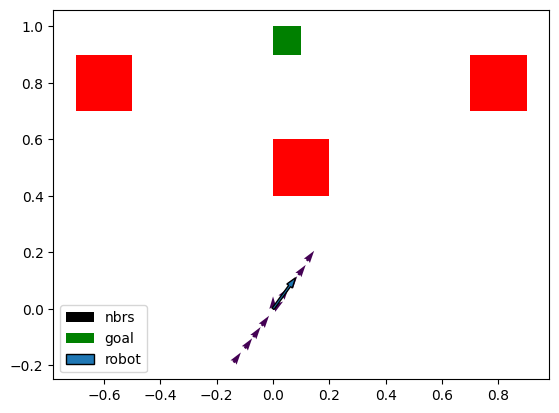

In [16]:
graph = ObstacleListToGraph(map, robot)
start_state = np.array([0., 0., 3*np.pi/10])
state_nbrs = graph.get(start_state)
fig, ax = plt.subplots()
state_nbrs_plot = state_nbrs[::5, :]
ax.quiver(state_nbrs_plot[:, 0], state_nbrs_plot[:, 1], 
          np.cos(state_nbrs_plot[:, 2]), np.sin(state_nbrs_plot[:, 2]), 
          0.7,
          label='nbrs',
         scale=40)
plot_map(ax, map, goal, start_state, obstaclesize=0.2)
ax.legend()

In [17]:
state_nbrs

array([[ 0.03      ,  0.04      ,  0.9424778 ],
       [ 0.04      ,  0.05      ,  0.9424778 ],
       [ 0.04      ,  0.06      ,  0.9424778 ],
       [ 0.05      ,  0.06      ,  0.9424778 ],
       [ 0.05      ,  0.07      ,  0.9424778 ],
       [ 0.06      ,  0.08      ,  0.9424778 ],
       [ 0.07      ,  0.09      ,  0.9424778 ],
       [ 0.07      ,  0.1       ,  0.9424778 ],
       [ 0.08      ,  0.1       ,  0.9424778 ],
       [ 0.08      ,  0.11      ,  0.9424778 ],
       [ 0.09      ,  0.12      ,  0.9424778 ],
       [ 0.09      ,  0.13      ,  0.9424778 ],
       [ 0.1       ,  0.14      ,  0.9424778 ],
       [ 0.11      ,  0.15      ,  0.9424778 ],
       [ 0.12      ,  0.16      ,  0.9424778 ],
       [ 0.12      ,  0.17      ,  0.9424778 ],
       [ 0.13      ,  0.18      ,  0.9424778 ],
       [ 0.14      ,  0.19      ,  0.9424778 ],
       [-0.03      , -0.04      ,  0.9424778 ],
       [-0.04      , -0.05      ,  0.9424778 ],
       [-0.04      , -0.06      ,  0.942

I am satisfied with the list of all possible neighbors. 

But we also need the neighbors to be checked against obstacles and removed from the neighbor list. The neighbors returned must be only the ones that do not collide with obstacles. 

Let's add bounds to the obstacle description.

In [18]:
map = MapProperties(
    state_min = np.array([
        -1.0, # x min in meters
        -.1, # y min in meters
        -np.pi # theta min in radians
    ]),
    state_max = np.array([
        1.0, # x max in meters
        1.0, # y max in meters
        np.pi # theta max in radians
    ]),
    state_discrete_step = np.array([
        0.01, # x min in meters
        0.01, # y min in meters
        np.pi/20 # theta min in radians
    ]),
    # Let's put obstacles somewhere (arbitrary for now)
    obstacles = np.array([
        [0.7, 0.7, 0.2, 0.1], # x, y, width, height        
        [0., 0.4, 0.2, 0.1], # x, y, width, height        
        [-0.7, 0.7, 0.2, 0.1] # x, y, width, height
    ])
)


def plot_map(ax, map_properties, goal, current_state,
            goalsize=0.1,
            robotsize=0.1,
            obstaclecolor='r',
            goalcolor='g'):
    state_min = map_properties.state_min
    state_max = map_properties.state_max
    obstacles = map_properties.obstacles
    ax.set_xlim(state_min[0], state_max[0])
    ax.set_ylim(state_min[1], state_max[1])
    ax.axis('equal') # keeps square obstacles square
    
    # Draw the obstacle as rectangles
    # Had to google matplotlib + draw rectangle
    # https://stackoverflow.com/questions/37435369/how-to-draw-a-rectangle-on-image
    for obs in obstacles:
        xy = obs[:2]
        width, height = obs[2:]
        orect = patches.Rectangle(xy, width, height, facecolor=obstaclecolor)
        # Add the patch to the Axes
        ax.add_patch(orect)
    
    # Draw the goal as a rectangle
    grect = patches.Rectangle(goal, goalsize, goalsize, facecolor=goalcolor, label='goal')
    ax.add_patch(grect)
    
    # Draw the robot as an arrow
    # Google: matplotlib draw arrow
    ax.arrow(current_state[0], current_state[1], 
             robotsize*np.cos(current_state[2]), robotsize*np.sin(current_state[2]),
             width=0.08*robotsize,
             label='robot')
    return ax

In [19]:
class ObstacleListToGraph:
    def __init__(self, map_properties, robot):
        self.map = map_properties
        self.robot = robot

    def _discretize(self, s):
        # divide by the step size, then round to convert the number to the nearest integer
        # and then multiply by the step size again.
        return np.round(s / self.map.state_discrete_step) * self.map.state_discrete_step
        
    def _get_bounds(self, current_state):
        vmin, vmax = self.robot.linvel_range
        omegamin, omegamax = self.robot.angvel_range
        step_size = self.map.state_discrete_step
        dt = self.robot.dt
        s = np.asarray(current_state)

        # The max and min state cells are governed by 
        # max and min velocity both linear and angular
        s = self._discretize(s)
        state_min = s + np.array([
            vmin * np.cos(s[2]) * dt,
            vmin * np.sin(s[2]) * dt,
            omegamin * dt])
        state_min = self._discretize(state_min)
        xy_min = state_min[:2]
        theta_min_angle = wrap_theta(state_min[2]) # Angle type
        
        state_delta = np.array([
            (vmax - vmin) * np.cos(s[2]) * dt,
            (vmax - vmin) * np.sin(s[2]) * dt,
            (omegamax - omegamin) * dt
        ])
        state_delta = self._discretize(state_delta)
        xy_delta = state_delta[:2]
        theta_delta = state_delta[2]

        return s, xy_delta, xy_min, theta_delta, theta_min_angle, step_size
        
    def get_all_nbrs(self, current_state, default=[]):
        s, xy_delta, xy_min, theta_delta, theta_min_angle, step_size = self._get_bounds(current_state)
        xy_uniq_nbrs = self.get_lin_vel_nbrs(s, xy_delta, xy_min, step_size)
        
        xy_uniq_nbrs_opp = s[:2] - (xy_uniq_nbrs - s[:2])
        xy_both_side_nbrs = np.vstack((xy_uniq_nbrs, 
                                       xy_uniq_nbrs_opp))
        
        theta_nbrs_angle = self.get_ang_vel_nbrs(s, theta_delta, theta_min_angle, step_size)
        theta_angle = s[2] # Angle type
        
        # Note that for theta_nbrs_angle and theta_angle we use diff, but once we have that, we
        # use normal substraction with theta_angle.
        theta_nbrs_opp_angle = Angle.wrap(theta_angle - Angle.diff(theta_nbrs_angle, theta_angle))
        theta_both_side_nbrs_angle = np.unique(np.hstack((theta_nbrs_angle,
                                               theta_nbrs_opp_angle)))
        
        state_nbrs = np.empty((len(xy_both_side_nbrs) + len(theta_both_side_nbrs_angle), 3))
        state_nbrs[:len(xy_both_side_nbrs), :2] = xy_both_side_nbrs 
        state_nbrs[:len(xy_both_side_nbrs), 2] = theta_angle
        
        state_nbrs[len(xy_both_side_nbrs):, :2] = s[:2]
        state_nbrs[len(xy_both_side_nbrs):, 2] = theta_both_side_nbrs_angle
        return state_nbrs
        
    def get_lin_vel_nbrs(self, s, xy_delta, xy_min, step_size):
        # all the cells that lie on the straight line between xy_delta+xy_min and xy_min are
        # possible neighbors.
        xy_dist = np.sqrt(((xy_delta)**2).sum())
        min_step = np.min(step_size[:2])
        xy_max_steps = xy_dist / min_step
        xy_dir = min_step * np.array([np.cos(s[2]), np.sin(s[2])])
        xy_nbrs = np.arange(xy_max_steps)[:, None]*xy_dir + xy_min
        xy_uniq_nbrs = np.unique(
            np.round(xy_nbrs / step_size[:2]).astype(dtype=np.int64),
            axis=0
        ) * step_size[:2]
        return xy_uniq_nbrs

    def get_ang_vel_nbrs(self, s, theta_delta, theta_min_angle, step_size):
        theta_steps = theta_delta / step_size[2]
        theta_nbrs_angle = np.unique(Angle.wrap(np.arange(theta_steps)*step_size[2] + theta_min_angle))
        return theta_nbrs_angle

    def get(self, current_state, default=[]):
        all_nbrs = self.get_all_nbrs(current_state, default)
        nbrs_xy = all_nbrs[:, :2] # Nx2 with N neighbors and 2 dim x, y. the orientation of robot does not matter for obstacles
        obstacles_xy = self.map.obstacles[:, :2] # Ox2
        obstacles_wh = self.map.obstacles[:, 2:] # Ox2
        nbr_obs_diff = nbrs_xy[:, None, :] - obstacles_xy[None, :, :] # NxOx2
        is_nbr_in_obs = ((0 <= nbr_obs_diff) & (nbr_obs_diff < obstacles_wh)).all(axis=-1) # NxO
        is_nbr_in_any_obs = is_nbr_in_obs.any(axis=-1) # N
        return all_nbrs[~is_nbr_in_any_obs, :] # Return all neighbors that are outside obstacles

But we also need the cost of taking action with each neighbor. The costs are very problem dependent. If you are a truck driver, the energy costs matter the most but if you are a F1 drive the time cost is of utmost important. One thing we can do in a principled way (or close enough) is set a relative cost between angular velocity and linear velocity neighbors. 

We can do it in a more principled way if we knew the mass to moment of inertia. Anyway, we are not working in acceleration domain, so we will stick to crude approximations. We would take half the distance travelled by each wheel to be a measure of the cost. The cost of moving $d$ distance forward or backward is $d$. The separation between two wheels is $L = 0.12$m so the cost of turning by $\theta$ radian is $L\theta/2$. 

Let's add this to graph class.

In [20]:
@dataclass
class Robot:
    linvel_range: np.ndarray
    angvel_range: np.ndarray
    dt: float 
    wheel_base: float

robot = Robot(linvel_range = np.array([0.1, 0.5]),
              angvel_range = np.array([np.pi/10, 3*np.pi/4]),
              wheel_base = 0.12,
              dt = None)

robot.dt = max(
    np.sqrt((map.state_discrete_step[:2]**2).sum()) / np.abs(robot.linvel_range[0]),
    map.state_discrete_step[2] / np.abs(robot.angvel_range[0]))


def do_points_collide(map, xy_nbrs):
    # Nx2 with N neighbors and 2 dim x, y. the orientation of robot does not matter for obstacles
    in_bounds = (
        (map.state_min[:2] <= xy_nbrs) & 
        (xy_nbrs < map.state_max[:2])).all(axis=-1)
    
    obstacles_xy = map.obstacles[:, :2] # Ox2
    obstacles_wh = map.obstacles[:, 2:] # Ox2
    
    nbr_obs_diff = xy_nbrs[:, None, :] - obstacles_xy[None, :, :] # NxOx2
    is_nbr_in_obs = ((0 <= nbr_obs_diff) & (nbr_obs_diff < obstacles_wh)).all(axis=-1) # NxO
    is_nbr_in_any_obs = is_nbr_in_obs.any(axis=-1) # N
    return is_nbr_in_any_obs | (~in_bounds)


class ObstacleListToGraph:
    def __init__(self, map_properties, robot):
        self.map = map_properties
        self.robot = robot

    def _discretize(self, s):
        # divide by the step size, then round to convert the number to the nearest integer
        # and then multiply by the step size again.
        return np.round(s / self.map.state_discrete_step) * self.map.state_discrete_step
        
    def _get_bounds(self, current_state):
        vmin, vmax = self.robot.linvel_range
        omegamin, omegamax = self.robot.angvel_range
        step_size = self.map.state_discrete_step
        dt = self.robot.dt
        s = np.asarray(current_state)

        # The max and min state cells are governed by 
        # max and min velocity both linear and angular
        s = self._discretize(s)
        state_min = s + np.array([
            vmin * np.cos(s[2]) * dt,
            vmin * np.sin(s[2]) * dt,
            omegamin * dt])
        state_min = self._discretize(state_min)
        xy_min = state_min[:2]
        theta_min_angle = Angle.wrap(state_min[2]) # Angle type
        
        state_delta = np.array([
            (vmax - vmin) * np.cos(s[2]) * dt,
            (vmax - vmin) * np.sin(s[2]) * dt,
            (omegamax - omegamin) * dt
        ])
        state_delta = self._discretize(state_delta)
        xy_delta = state_delta[:2]
        theta_delta = state_delta[2]

        return s, xy_delta, xy_min, theta_delta, theta_min_angle, step_size
        
    def get_all_nbrs(self, current_state, default):
        s, xy_delta, xy_min, theta_delta, theta_min_angle, step_size = self._get_bounds(current_state)
        xy_uniq_nbrs = self.get_lin_vel_nbrs(s, xy_delta, xy_min, step_size)
        
        xy_uniq_nbrs_opp = self.get_lin_vel_nbrs(s, -xy_delta, 
                                                 s[:2] - (xy_min - s[:2]), # xy_min in opposite dir
                                                 step_size)
        xy_both_side_nbrs = np.vstack((xy_uniq_nbrs, 
                                       xy_uniq_nbrs_opp))
        
        theta_nbrs_angle = self.get_ang_vel_nbrs(s, theta_delta, theta_min_angle, step_size)
        theta_angle = s[2] # Angle type
        
        # Note that for theta_nbrs_angle and theta_angle we use diff, but once we have that, we
        # use normal substraction with theta_angle.
        theta_nbrs_opp_angle = Angle.wrap(theta_angle - Angle.diff(theta_nbrs_angle, theta_angle))
        theta_both_side_nbrs_angle = np.unique(np.hstack((theta_nbrs_angle,
                                               theta_nbrs_opp_angle)))
        
        state_nbrs = np.empty((len(xy_both_side_nbrs) + len(theta_both_side_nbrs_angle), 3))
        state_nbrs[:len(xy_both_side_nbrs), :2] = xy_both_side_nbrs 
        state_nbrs[:len(xy_both_side_nbrs), 2] = theta_angle
        
        state_nbrs[len(xy_both_side_nbrs):, :2] = s[:2]
        state_nbrs[len(xy_both_side_nbrs):, 2] = theta_both_side_nbrs_angle
        return state_nbrs
        
    def get_lin_vel_nbrs(self, s, xy_delta, xy_min, step_size):
        # all the cells that lie on the straight line between xy_delta+xy_min and xy_min are
        # possible neighbors.
        xy_dist = np.sqrt((xy_delta**2).sum())
        min_step = np.min(step_size[:2])
        xy_max_steps = xy_dist / min_step
        xy_dir = min_step * (xy_min - s[:2]) / np.linalg.norm((xy_min - s[:2]))

        xy_nbrs = np.arange(xy_max_steps+1)[:, None]*xy_dir + xy_min
        
        # Check neighbors for collision or being out of bound
        collisions = do_points_collide(self.map, xy_nbrs)
        if collisions[0]:
            return np.empty((0, 2)) # No nbr that does not collide
        indices, = np.nonzero(collisions)
        xy_non_colliding = xy_nbrs[:indices[0]-1] if len(indices) else xy_nbrs
        
        xy_uniq_nbrs = np.unique(
            np.round(xy_non_colliding / step_size[:2]).astype(dtype=np.int64),
            axis=0
        ) * step_size[:2]
        return xy_uniq_nbrs

    def get_ang_vel_nbrs(self, s, theta_delta, theta_min_angle, step_size):
        theta_steps = theta_delta / step_size[2]
        theta_nbrs_angle = np.unique(Angle.wrap(np.arange(theta_steps+1)*step_size[2] + theta_min_angle))
        return theta_nbrs_angle


    def get_nbrs_np(self, current_state, default):
        L = self.robot.wheel_base
        nbrs = self.get_all_nbrs(current_state, default)
        s = np.asarray(current_state)
        nbrs_diff = nbrs[:, :2] - s[:2]
        edge_cost = np.sqrt((nbrs_diff**2).sum(axis=-1)) + L*Angle.dist(nbrs[:, 2], s[2])/2
        return nbrs, edge_cost

    def get(self, current_state, default=[]):
        nbrs, edge_cost = self.get_nbrs_np(current_state, default)
        return [(tuple(nbr), ecost) 
                for nbr, ecost in zip(nbrs.tolist(), edge_cost.tolist())]

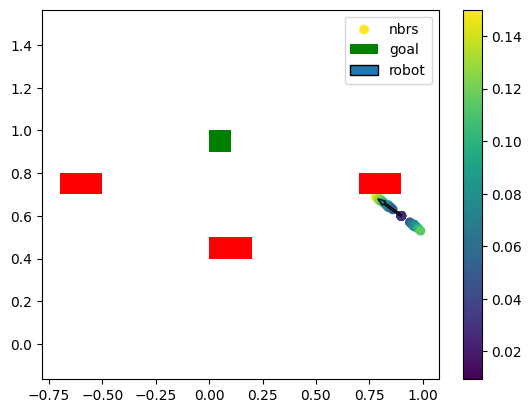

In [21]:
graph = ObstacleListToGraph(map, robot)
start_state = np.array([0.9, 0.6, Angle.wrap(8*np.pi/10)])
state_nbrs, edge_costs = graph.get_nbrs_np(start_state, [])

fig, ax = plt.subplots()
a = ax.scatter(state_nbrs[:, 0], state_nbrs[:, 1], c=edge_costs,  label='nbrs')
plot_map(ax, map, goal, start_state)
fig.colorbar(a)
ax.legend()

In [22]:
def euclidean_heurist_dist(node, goal):
    x_n, y_n, theta_n = node
    x_g, y_g = goal
    return np.sqrt((x_n-x_g)**2 + (y_n - y_g)**2)

In [23]:
from astar import astar
#success, search_path, node2parent, node2dist = astar(graph, euclidean_heurist_dist, tuple(start_state.tolist()), goal)

The above code takes forever to run. We need to lower the graph complexity.

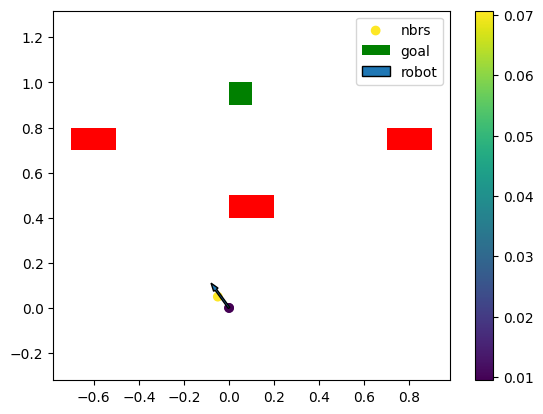

In [24]:
@dataclass
class Robot:
    linvel_range: np.ndarray
    angvel_range: np.ndarray
    dt: float 
    wheel_base: float

robot = Robot(linvel_range = np.array([0.1, 0.1]),
              angvel_range = np.array([np.pi/10, np.pi/10]),
              wheel_base = 0.12,
              dt = None)
robot.dt = max(
    np.sqrt((map.state_discrete_step[:2]**2).sum()) / np.abs(robot.linvel_range[0]),
    map.state_discrete_step[2] / np.abs(robot.angvel_range[0]))

map = MapProperties(
    state_min = np.array([
        -1.0, # x min in meters
        0.0, # y min in meters
        -np.pi # theta min in radians
    ]),
    state_max = np.array([
        1.0, # x max in meters
        1.0, # y max in meters
        np.pi # theta max in radians
    ]),
    state_discrete_step = np.array([
        0.05, # x min in meters
        0.05, # y min in meters
        np.pi/20 # theta min in radians
    ]),
    # Let's put obstacles somewhere (arbitrary for now)
    obstacles = np.array([
        [0.7, 0.7, 0.2, 0.1], # x, y, width, height        
        [0., 0.4, 0.2, 0.1], # x, y, width, height        
        [-0.7, 0.7, 0.2, 0.1] # x, y, width, height
    ])
)


graph = ObstacleListToGraph(map, robot)
start_state = np.array([0., 0., Angle.wrap(7*np.pi/10)])
state_nbrs, edge_costs = graph.get_nbrs_np(start_state, [])

fig, ax = plt.subplots()
a = ax.scatter(state_nbrs[:, 0], state_nbrs[:, 1], c=edge_costs,  label='nbrs')
plot_map(ax, map, goal, start_state)
fig.colorbar(a)
ax.legend()

In [25]:
state_nbrs

array([[-0.05      ,  0.05      ,  2.19911486],
       [ 0.        ,  0.        ,  2.04203522],
       [ 0.        ,  0.        ,  2.35619449]])

In [26]:
# success, search_path, node2parent, node2dist = astar(
#     graph, 
#     euclidean_heurist_dist, 
#     tuple(start_state.tolist()), goal,
#     debug=True,
#     debugf=open('log.txt', 'w'))

It looks like our search never reaches the goal. We need to make the goal check function a region check instead of node check.

In [27]:
%%writefile astar2.py
from hw2_solution import PriorityQueueUpdatable
import sys
from dataclasses import dataclass, field
from typing import Any

# https://docs.python.org/3/library/queue.html#queue.PriorityQueue
@dataclass(order=True)
class PItem:
    dist: int
    node: Any=field(compare=False)

    # Make the PItem hashable
    # https://docs.python.org/3/glossary.html#term-hashable
    def __hash__(self):
        return hash(self.node)

def default_goal_check(m, goal):
    return m == goal

def astar(graph, heuristic_dist_fn, start, goal, 
          goal_check=default_goal_check, 
          debug=False, 
          debugf=sys.stdout):
    """
    edgecost: cost of traversing each edge
    
    Returns success and node2parent
    
    success: True if goal is found otherwise False
    node2parent: A dictionary that contains the nearest parent for node 
    """
    seen = set([start]) # Set for seen nodes.
    # Frontier is the boundary between seen and unseen
    frontier = PriorityQueueUpdatable() # Frontier of unvisited nodes as a Priority Queue
    node2parent = {start : None} # Keep track of nearest parent for each node (requires node to be hashable)
    hfn = heuristic_dist_fn # make the name shorter
    node2dist = {start: 0  } # Keep track of cost to arrive at each node
    search_order = []
    frontier.put(PItem(0 + hfn(start, goal), start)) #   <------------- Different from dijkstra
    
    if debug: debugf.write("goal = "  + str(goal) + '\n')
    i = 0
    while not frontier.empty():          # Creating loop to visit each node
        dist_m = frontier.get() # Get the smallest addition to the frontier
        if debug: debugf.write("%d) Q = " % i + str(list(frontier.queue)) + '\n')
        if debug: debugf.write("%d) node = " % i + str(dist_m) + '\n')
        #if debug: print("dists = " , [node2dist[n.node] for n in frontier.queue])
        m = dist_m.node
        m_dist = node2dist[m]
        search_order.append(m)
        if goal is not None and goal_check(m, goal):
            return True, search_order, node2parent, node2dist

        for neighbor, edge_cost in graph.get(m, []):
            old_dist = node2dist.get(neighbor, float("inf"))
            new_dist = edge_cost +  m_dist 
            if neighbor not in seen:
                seen.add(neighbor)
                frontier.put(PItem(new_dist +  hfn(neighbor, goal), neighbor)) # <------------- Different from dijkstra
                node2parent[neighbor] = m
                node2dist[neighbor] = new_dist
            elif new_dist < old_dist:
                node2parent[neighbor] = m
                node2dist[neighbor] = new_dist
                # ideally you would update the dist of this item in the priority queue
                # as well. But python priority queue does not support fast updates
                # ------------- Different from dijkstra --------------------
                old_item = PItem(old_dist + hfn(neighbor, goal), neighbor)
                if old_item in frontier:
                    frontier.replace(
                        old_item, 
                        PItem(new_dist + hfn(neighbor, goal), neighbor))
        i += 1
    if goal is not None:
        return False, search_order, node2parent, node2dist
    else:
        return True, search_order, node2parent, node2dist

def backtrace_path(node2parent, start, goal):
    c = goal
    r_path = [c]
    parent = node2parent.get(c, None)
    while parent != start:
        r_path.append(parent)
        c = parent
        parent = node2parent.get(c, None) # Keep getting the parent until you reach the start
        #print(parent)
    r_path.append(start)
    return reversed(r_path) # Reverses the path

Overwriting astar2.py


In [28]:
from astar2 import astar, backtrace_path
def goal_check_region(m, goal, goal_wh=(0.1, 0.1)):
    m = np.asarray(m)
    goal = np.asarray(goal)
    goal_wh = np.asarray(goal_wh)
    mdiff = (m[:2] - goal)
    return ((0 <= mdiff) & (mdiff <= goal_wh)).all()

start_state = np.array([0., 0., 3*np.pi/10])
start_node_tuple = tuple(start_state.tolist())
success, search_path, node2parent, node2dist = astar(
    graph, 
    euclidean_heurist_dist, 
    start_node_tuple, goal,
    goal_check=goal_check_region,
    debug=True,
    debugf=open('log.txt', 'w'))

In [29]:
path = np.array(list(backtrace_path(node2parent, start_node_tuple, search_path[-1])))

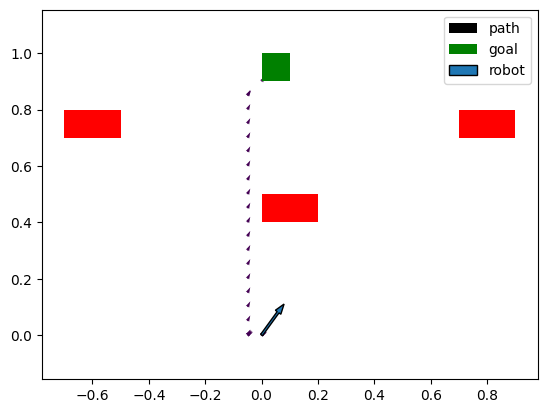

In [30]:
fig, ax = plt.subplots()
ax.quiver(path[:, 0], path[:, 1], np.cos(path[:, 2]), np.sin(path[:, 2]), 1., scale=80, label='path')
plot_map(ax, map, goal, start_state)
ax.legend()

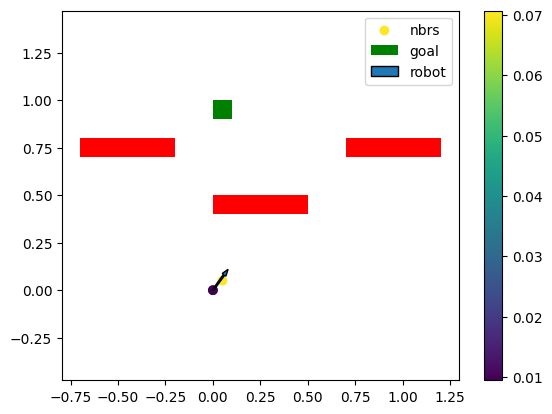

In [31]:
robot = Robot(linvel_range = np.array([0.1, 0.1]),
              angvel_range = np.array([np.pi/10, np.pi/10]),
              wheel_base = 0.12,
              dt = None)
robot.dt = max(
    np.sqrt((map.state_discrete_step[:2]**2).sum()) / np.abs(robot.linvel_range[0]),
    map.state_discrete_step[2] / np.abs(robot.angvel_range[0]))

map = MapProperties(
    state_min = np.array([
        -1.0, # x min in meters
        0.0, # y min in meters
        -np.pi # theta min in radians
    ]),
    state_max = np.array([
        1.0, # x max in meters
        1.0, # y max in meters
        np.pi # theta max in radians
    ]),
    state_discrete_step = np.array([
        0.05, # x min in meters
        0.05, # y min in meters
        np.pi/20 # theta min in radians
    ]),
    # Let's put obstacles somewhere (arbitrary for now)
    obstacles = np.array([
        [0.7, 0.7, 0.5, 0.1], # x, y, width, height        
        [0., 0.4, 0.5, 0.1], # x, y, width, height        
        [-0.7, 0.7, 0.5, 0.1] # x, y, width, height
    ])
)

graph = ObstacleListToGraph(map, robot)
start_state = np.array([0., 0., Angle.wrap(3*np.pi/10)])
state_nbrs, edge_costs = graph.get_nbrs_np(start_state, [])

fig, ax = plt.subplots()
a = ax.scatter(state_nbrs[:, 0], state_nbrs[:, 1], c=edge_costs,  label='nbrs')
plot_map(ax, map, goal, start_state)
fig.colorbar(a)
ax.legend()

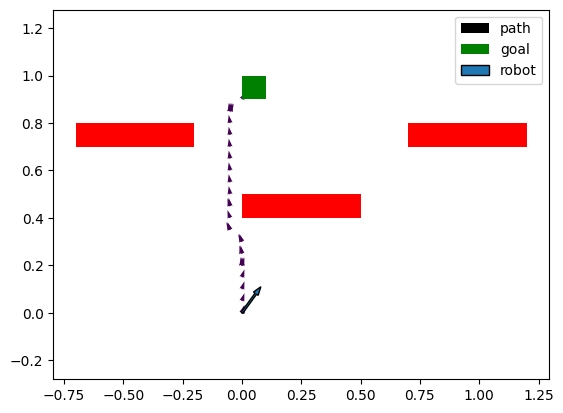

In [32]:
start_state = np.array([0., 0., 3*np.pi/10])
start_node_tuple = tuple(start_state.tolist())
success, search_path, node2parent, node2dist = astar(
    graph, 
    euclidean_heurist_dist, 
    start_node_tuple, goal,
    goal_check=goal_check_region)

path = np.array(list(backtrace_path(node2parent, start_node_tuple, search_path[-1])))

fig, ax = plt.subplots()
ax.quiver(path[:, 0], path[:, 1], np.cos(path[:, 2]), np.sin(path[:, 2]), 1., scale=60, label='path')
plot_map(ax, map, goal, start_state)
ax.legend()

This could also have been done with RRT. Once the RRT is implemented the graph construction is much easier with RRT.

In [50]:
np.random.seed(1010)
def closest_point_on_line_segs(edges, pt, dist_fn_rrt=lambda x, y: np.linalg.norm(x - y, axis=-1)):
    assert edges.shape[-2] == 2
    *N, _, D = edges.shape
    vs, ve = edges[:, 0, :], edges[:, 1, :]
    edge_vec = ve - vs # *N x D
    edge_mag = dist_fn_rrt(vs, ve)[..., None] #  *N
    edge_unit = edge_vec / edge_mag # *NxD
    
    # pt on edge = x = vs + t * edge_unit
    # (x - pt) @ edge_unit = 0
    # ((vs + t * edge_unit) - pt) @ edge_unit = 0
    # t = (pt - vs) @ edge_unit
    t = ((pt - vs) * edge_unit).sum(axis=-1, keepdims=True) # N x 1
    x = vs + t * edge_unit # *N x D
    dist_e = dist_fn_rrt(pt , x)#, axis=-1)
    dist_vs = dist_fn_rrt(vs , pt)#, axis=-1)
    dist_ve = dist_fn_rrt(ve , pt)#, axis=-1)
    is_pt_on_edge = ((0 <= t) & (t <= edge_mag))[..., 0]
    dist_v = np.minimum(dist_vs, dist_ve)
    dist = np.where( is_pt_on_edge,
                    dist_e,
                    dist_v)
    min_idx = np.argmin(dist)
    closest_point =  (x[min_idx]
                      if is_pt_on_edge[min_idx] else vs[min_idx]
                      if (dist_vs[min_idx] < dist_ve[min_idx]) else ve[min_idx])
    return closest_point, dist[min_idx], ([(vs[min_idx], ve[min_idx])]
                                          if is_pt_on_edge[min_idx] else [])

def closest_point_on_graph(G_adjacency_list, pt, dist_fn_rrt):
    vertices = list(G_adjacency_list.keys())
    edge_list = sum(
        [[(v, n) 
         for n, e in nbrs]
         for v, nbrs in G_adjacency_list.items()], [])
    if len(edge_list):
        return closest_point_on_line_segs(np.array(edge_list), pt, dist_fn_rrt)
    else:
        verticesnp = np.array(vertices)
        dists_v = dist_fn_rrt(verticesnp, pt)#, axis=-1)
        min_idx = np.argmin(dists_v)
        closest_point_v = verticesnp[min_idx]
        return closest_point_v, dists_v[min_idx], []

def rrt_one_step(map, G_adjacency_list, do_points_collide_rrt, closest_point_on_graph_rrt, 
                 random_pt, dist_fn_rrt, stepsize):
    # 2.B Connect the sampled point to the nearest point (vertex or edge) 
    # on the graph, as long as the connecting line does not pass through the obstacle.
    nearest_pt, dist, edges_to_delete = closest_point_on_graph_rrt(
        G_adjacency_list, random_pt, dist_fn_rrt)
    dist_norm = np.linalg.norm(random_pt - nearest_pt) # not using dist_fn_rrt here
    steps = int(np.floor(dist_norm / stepsize))
    if steps <= 0:
        return False, [], []
    direction = (random_pt - nearest_pt) / dist_norm
    all_points = np.arange(1, steps + 1)[:, None]*stepsize*direction+ nearest_pt[None, :]
    collisions = do_points_collide_rrt(map, all_points)
    if collisions[0]:
        return False, [], []
    indices, = np.nonzero(collisions)
    first_non_colliding = (all_points[indices[0]-1] if len(indices)  else random_pt)
    dist_fnc = dist_fn_rrt(first_non_colliding, nearest_pt)
    nearest_pt_tuple = tuple(nearest_pt.tolist())
    first_non_colliding_tuple = tuple(first_non_colliding.tolist())
    edges_to_add = [(nearest_pt_tuple, (first_non_colliding_tuple, dist_fnc))]
    edges_to_delete_tupled = []
    for vs, ve in edges_to_delete:
        vs_dist = dist_fn_rrt(nearest_pt, vs)
        vs_tuple = tuple(vs.tolist())
        edges_to_add.append((vs_tuple, (nearest_pt_tuple, vs_dist)))
        
        ve_dist = dist_fn_rrt(ve, nearest_pt)
        ve_tuple = tuple(ve.tolist())
        edges_to_add.append((nearest_pt_tuple, (ve_tuple, ve_dist)))

        edges_to_delete_tupled.append((vs_tuple, ve_tuple))
    
    return True, edges_to_add, edges_to_delete_tupled

def rrt_explore(
        map, # map details with obstacles
        start, # start node as a tuple
        closest_point_on_graph_rrt,
        do_points_collide_rrt,
        dist_fn_rrt,
        goal_node,
        Npts=100, # we are going to sample 100 points, but start with 1 point
        stepsize=0.01
    ):
    # Specify the bounds of the map
    pt_min = map.state_min
    pt_max = map.state_max
    D = len(map.state_min)
    
    
    # 1. Initialize an empty graph with the start point
    G_adjacency_list = { start : [] }
    
    # 2. While not done
    for i in range(Npts):
        # 2.a Sample points on the chosen area.
        if i == Npts - 1:
            random_pt = np.asarray(goal_node)
        else:
            random_pt = np.random.rand(D) * (pt_max - pt_min) + pt_min
        # 2.B Connect the sampled point to the nearest point (vertex or edge) 
        # on the graph, as long as the connecting line does not pass through the obstacle.
        success, edges_to_add, edges_to_delete = rrt_one_step(
            map, G_adjacency_list, do_points_collide_rrt, closest_point_on_graph_rrt, 
            random_pt, dist_fn_rrt, stepsize)
        if success:
            for nearest_pt_tuple, (first_non_colliding_tuple, dist) in edges_to_add:
                G_adjacency_list.setdefault(
                    nearest_pt_tuple, []
                                        ).append(
                    (first_non_colliding_tuple, dist))
            for nearest_pt_tuple, pt2_tuple in edges_to_delete:
                nbrs = G_adjacency_list.get(nearest_pt_tuple, [])
                if len(nbrs):
                    idx = [n for n, e in nbrs].index(pt2_tuple)
                    nbrs.pop(idx)

        if i % 100 == 0:
            fig, ax = plt.subplots()
            ax.text(-0.75, 1,'%d' % i)
            plot_map(ax, map, goal, start)
            plot_graph(ax, G_adjacency_list)
            plt.show()
    return G_adjacency_list

def plot_graph(ax, G_adjacency_list):
    ax.axis('equal')
    for v, nbrs in G_adjacency_list.items():
        for n, e in nbrs:
            ax.plot([v[0], n[0]], [v[1], n[1]], 'k--')

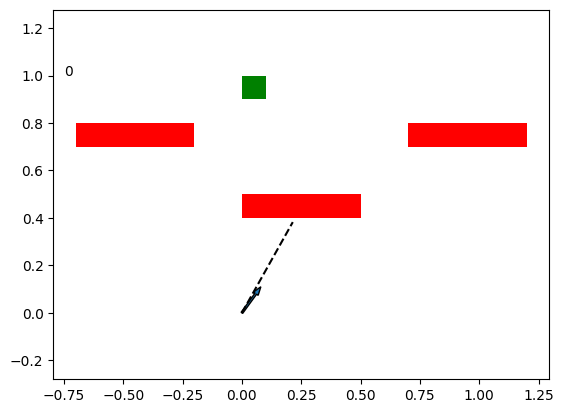

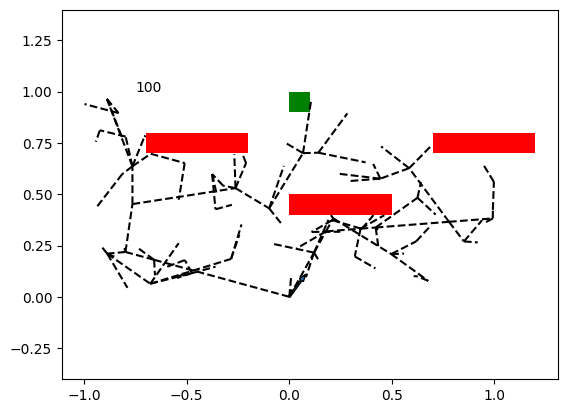

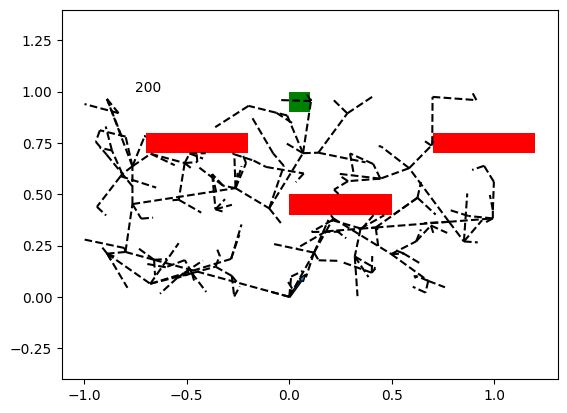

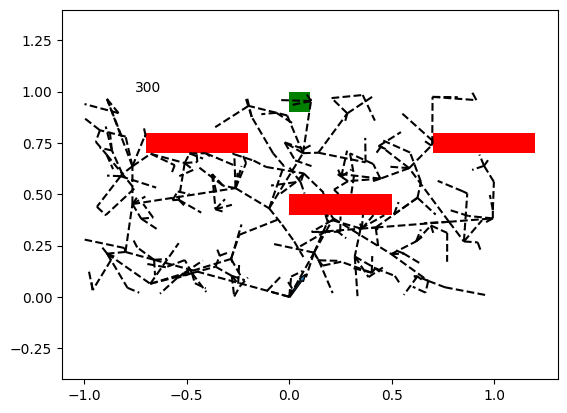

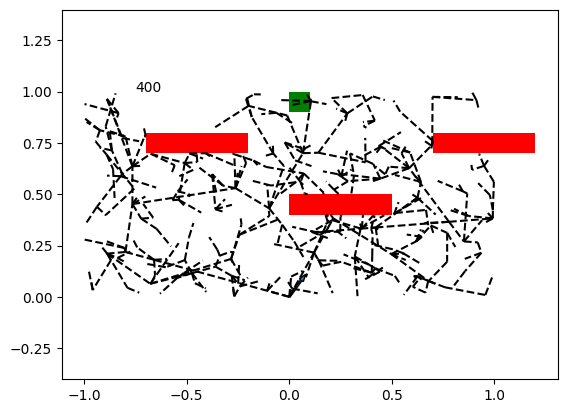

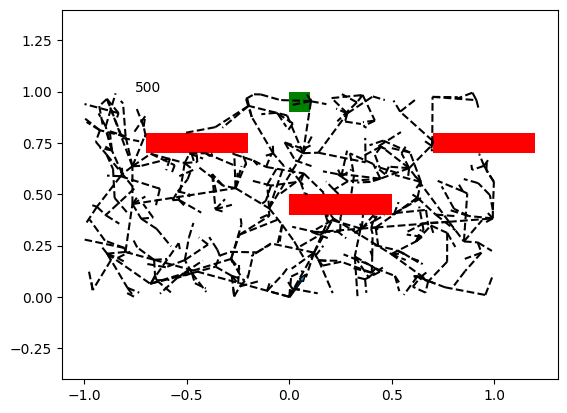

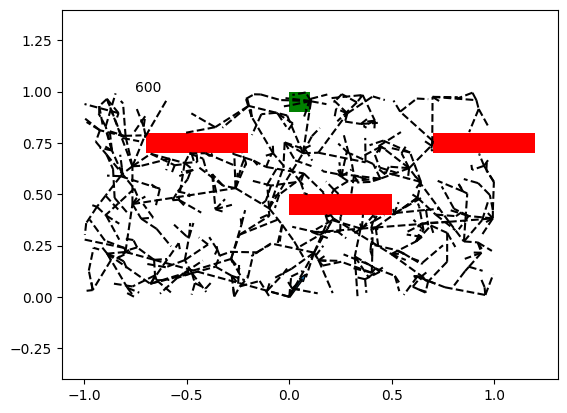

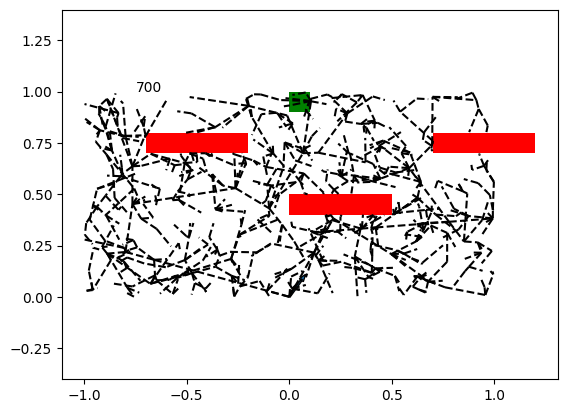

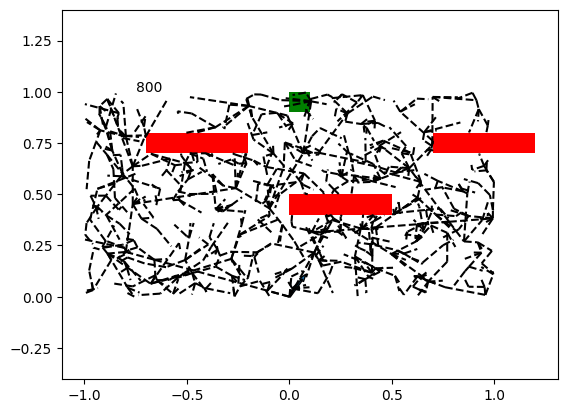

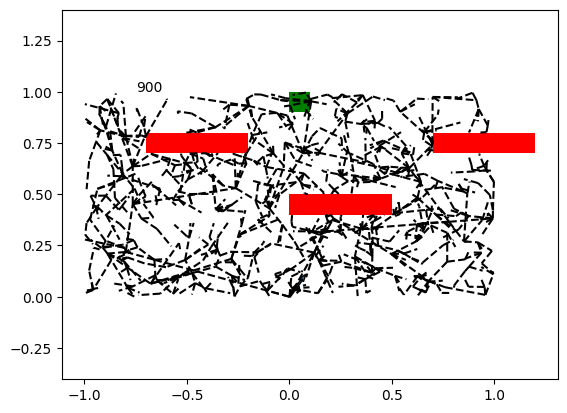

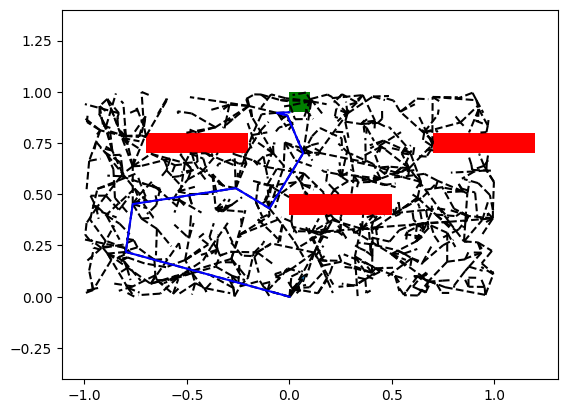

In [52]:
start_state = np.array([0., 0., 3*np.pi/10])
start_node_tuple = tuple(start_state.tolist())

def do_points_collide_rrt(map, all_points):
    return do_points_collide(map, all_points[:, :2])

def dist_fn_rrt(robot, end, start):
    L = robot.wheel_base
    nbrs_diff = end[..., :2] - start[..., :2]
    nbrs_dir = nbrs_diff / np.linalg.norm(nbrs_diff, axis=-1, keepdims=True)
    move_angle = np.arctan2(nbrs_dir[..., 1], nbrs_dir[..., 0])
    return (L*Angle.dist(Angle.wrap(start[..., 2]), move_angle)/2 # Turn toward y
            + np.sqrt((nbrs_diff**2).sum(axis=-1)) # Move
            + L*Angle.dist(move_angle, Angle.wrap(end[..., 2]))/2) # Turn toward desired orientation

G_rrt = rrt_explore(map, start_node_tuple,
                   closest_point_on_graph_rrt=closest_point_on_graph,
                   do_points_collide_rrt=do_points_collide_rrt,
                   dist_fn_rrt=lambda x, y: dist_fn_rrt(robot, x, y),
                   goal_node=(goal[0], goal[1], 0.0),
                   Npts=1000, stepsize=0.05)

success, search_path, node2parent, node2dist = astar(
    G_rrt, 
    euclidean_heurist_dist, 
    start_node_tuple, goal,
    goal_check=goal_check_region)

path = np.array(list(backtrace_path(node2parent, start_node_tuple, search_path[-1])))

fig, ax = plt.subplots()
plot_map(ax, map, goal, start_node_tuple)
plot_graph(ax, G_rrt)

#ax.quiver(path[:, 0], path[:, 1], np.cos(path[:, 2]), np.sin(path[:, 2]), 0.1, scale=60, label='path')
ax.plot(path[:, 0], path[:, 1], 'b-', label='path')